In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install catboost

# for EDA
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import matplotlib.ticker as mtick
# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_classif,f_regression, f_classif, chi2
# feature scaler
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
# for fixing the imbalanced dataset and split
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE

# for model evaluation
from sklearn.metrics import accuracy_score, roc_auc_score,mean_squared_error
from sklearn.metrics import confusion_matrix, RocCurveDisplay,classification_report # Use RocCurveDisplay instead of plot_roc_curve

# models selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB # Import GaussianNB class

# for the gridsearch
from sklearn.model_selection import GridSearchCV

**Loading** **Dataset**

In [3]:
# loading data
df1 = pd.read_csv('/content/drive/My Drive/diabetes_binary_5050.csv')
df2 = pd.read_csv('/content/drive/My Drive/diabetes_binary.csv')

print('df1 shape is: {}'.format(df1.shape))
print('df2 shape is: {}'.format(df2.shape))

df1 shape is: (70692, 22)
df2 shape is: (253680, 22)


 **Dataset** **Before** **Cleanup**

In [4]:
#describing the dataset
df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_binary       253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
# Check for null values
null_counts = df1.isnull().sum()
null_counts2 = df2.isnull().sum()

print(null_counts)
print(null_counts2)

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0


 **Data** **Preprocessing**

In [6]:
# checking if there missing values
df2.isna().sum()
df2.describe()

#checking for duplicates
duplicates = df2[df2.duplicated()]
num_duplicates = len(duplicates)
print(f"Number of Duplicate Rows: {num_duplicates}")
duplicates.head()

def data_clean(dataframe):
    # Define bins and labels for BMI categorization
    bins = [0, 18.5, 24.9, 29.9, float('inf')]
    labels = [1, 2, 3, 4]

    # Drop duplicates and assign BMI bins
    df = dataframe.drop_duplicates().assign(BMI_bins=dataframe['BMI'].pipe(pd.cut, bins=bins, labels=labels))

    # Reset the index and convert data types
    df = df.reset_index(drop=True).astype({'Diabetes_binary': 'uint8','HighBP': 'uint8',
    'HighChol': 'uint8',
    'CholCheck': 'uint8',
    'BMI': 'uint8',
    'Smoker': 'uint8',
    'Stroke': 'uint8',
    'HeartDiseaseorAttack': 'uint8',
    'PhysActivity': 'uint8',
    'Fruits': 'uint8',
    'Veggies': 'uint8',
    'HvyAlcoholConsump': 'uint8',
    'AnyHealthcare': 'uint8',
    'NoDocbcCost': 'uint8',
    'GenHlth': 'uint8',
    'MentHlth': 'uint8',
    'PhysHlth': 'uint8',
    'DiffWalk': 'uint8',
    'Sex': 'uint8',
    'Age': 'uint8',
    'Education': 'uint8',
    'Income': 'uint8',
    'BMI_bins': 'uint8'
    })

    return df # Indent all lines within the function

Number of Duplicate Rows: 24206


**Dataset After Cleaning**

In [7]:
#cleaned dataset df
df = data_clean(df2)
df1_clean = data_clean(df1)
df.info()

# Get a description for all columns in the dataframe without transposing
df.describe(include='all').T

#Grouping variables
# Define the target variable
target = 'Diabetes_binary'

# Identify boolean variables (binary) and numeric variables
bool_vars = df2.columns[df2.nunique() == 2].difference([target])
num_vars = [var for var in df2.columns if var not in bool_vars and var !=target]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229474 entries, 0 to 229473
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Diabetes_binary       229474 non-null  uint8
 1   HighBP                229474 non-null  uint8
 2   HighChol              229474 non-null  uint8
 3   CholCheck             229474 non-null  uint8
 4   BMI                   229474 non-null  uint8
 5   Smoker                229474 non-null  uint8
 6   Stroke                229474 non-null  uint8
 7   HeartDiseaseorAttack  229474 non-null  uint8
 8   PhysActivity          229474 non-null  uint8
 9   Fruits                229474 non-null  uint8
 10  Veggies               229474 non-null  uint8
 11  HvyAlcoholConsump     229474 non-null  uint8
 12  AnyHealthcare         229474 non-null  uint8
 13  NoDocbcCost           229474 non-null  uint8
 14  GenHlth               229474 non-null  uint8
 15  MentHlth              229474 non-n

# **Outlier Detection**

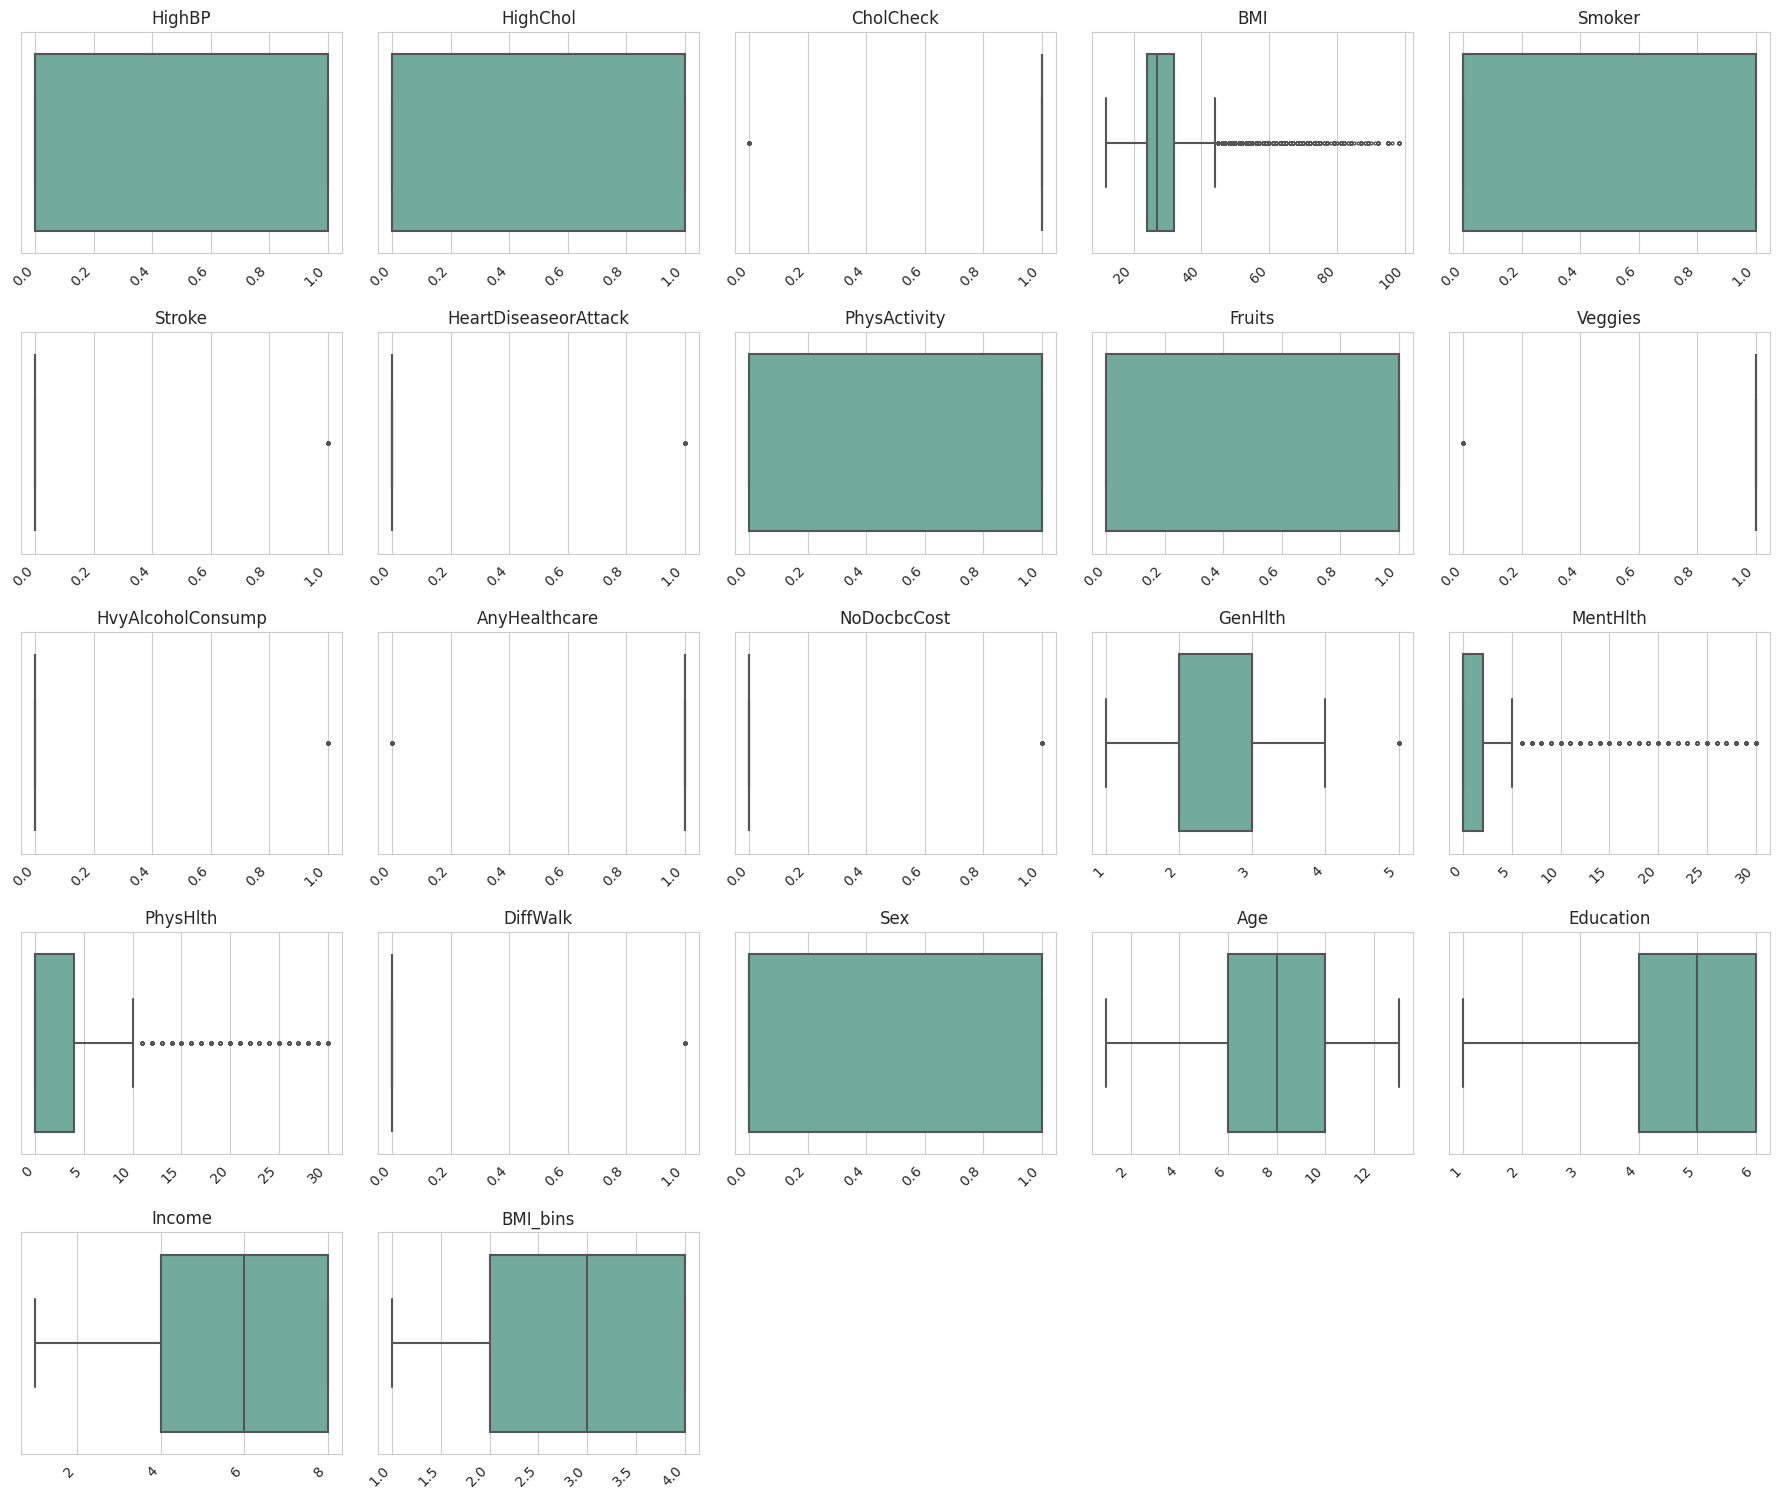

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the features to plot
features = [
    'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker', 'Stroke',
    'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
    'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
    'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
    'Income', 'BMI_bins'
]

# Set the overall figure size
plt.figure(figsize=(18, 15))
sns.set_style('whitegrid')  # Use a clean style for the grid

# Loop through the features and create a subplot for each
for i, feature in enumerate(features, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x=df[feature], color='#69b3a2', fliersize=2, linewidth=1.5)
    plt.title(feature, fontsize=12)
    plt.xlabel('')  # Remove x-axis label for cleaner look
    plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for readability

plt.tight_layout()  # Adjusts the plots to fit into the figure area nicely
plt.show()


**Data Visualization of Target Variable**

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64
Diabetes_binary
1    15.29%
0    84.71%
Name: proportion, dtype: object



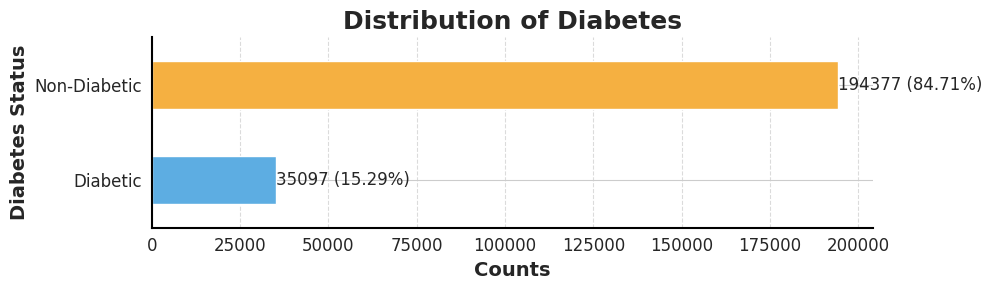

In [9]:
import matplotlib.pyplot as plt

# Calculate and print the counts and percentages of 'Diabetes_binary'
diabetes_counts = df['Diabetes_binary'].value_counts(ascending=True)
diabetes_percentages = df['Diabetes_binary'].value_counts(normalize=True, ascending=True).apply(lambda x: format(x, '.2%'))

print(diabetes_counts)
print(diabetes_percentages)
print()

# Create a horizontal bar plot with enhanced color palette, data labels, and a frame
colors = ['#5DADE2', '#F5B041']  # Blue and orange color scheme

ax = diabetes_counts.plot(kind='barh', figsize=(10, 3), color=colors)
ax.spines[['top', 'right']].set_visible(False)

# Add frame to the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')  # Set frame color
    spine.set_linewidth(1.5)      # Set frame width

# Add counts and percentages on the bars
for i, (count, percentage) in enumerate(zip(diabetes_counts, diabetes_percentages)):
    ax.text(count + 1, i, f'{count} ({percentage})', va='center', fontsize=12)

# Title and labels
plt.title('Distribution of Diabetes', fontsize=18, weight='bold')
plt.xlabel('Counts', fontsize=14, weight='bold')
plt.ylabel('Diabetes Status', fontsize=14, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(ticks=[0, 1], labels=['Diabetic', 'Non-Diabetic'], fontsize=12)

# Add gridlines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

 **Data Visualization of Category Variables**

In [10]:
# Define unique colors for each plot
unique_colors = ['#4a031d', '#c9661e', '#3366FF', '#FF33CC', '#FFFF33',
                  '#33CCFF', '#FF3399', '#99FF33', '#FF6633', '#33FFCC']

#Data Visualization of Numeric Variable
def analyze_categorical_variable(variable_name):

    #Group the categorical variable by 'Diabetes_binary'
    grouped_data = df.groupby('Diabetes_binary')[variable_name].value_counts(1).unstack().iloc[:, ::-1] # Indent this line

    # Create a list of unique colors based on the number of categories
    num_categories = len(grouped_data.columns)
    colors = unique_colors[:num_categories]

    # Create the horizontal stacked bar plot
    ax = grouped_data.plot(kind='barh', stacked=True, figsize=(8, 1.5),
    color=colors, alpha=1)

    # Customize the plot appearance
    ax.spines[['top', 'right']].set_visible(False)
    plt.legend(grouped_data.columns, bbox_to_anchor=(1, 1, 0, 0), shadow=False, frameon=False)
    plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
    plt.tight_layout()
    plt.title(variable_name, fontsize=18)

    # Show the plot
    plt.show()

#cleaned dataset describe
df[num_vars].describe()

,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000,229474.000000
mean,28.687507,2.601820,3.509866,4.681219,8.085068,4.979741,5.888615
std,6.789204,1.064962,7.717643,9.050877,3.094451,0.992989,2.092888
min,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,4.000000
50%,27.000000,3.000000,0.000000,0.000000,8.000000,5.000000,6.000000
75%,32.000000,3.000000,2.000000,4.000000,10.000000,6.000000,8.000000
max,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


 **Data Visualization of Numeric Variable**

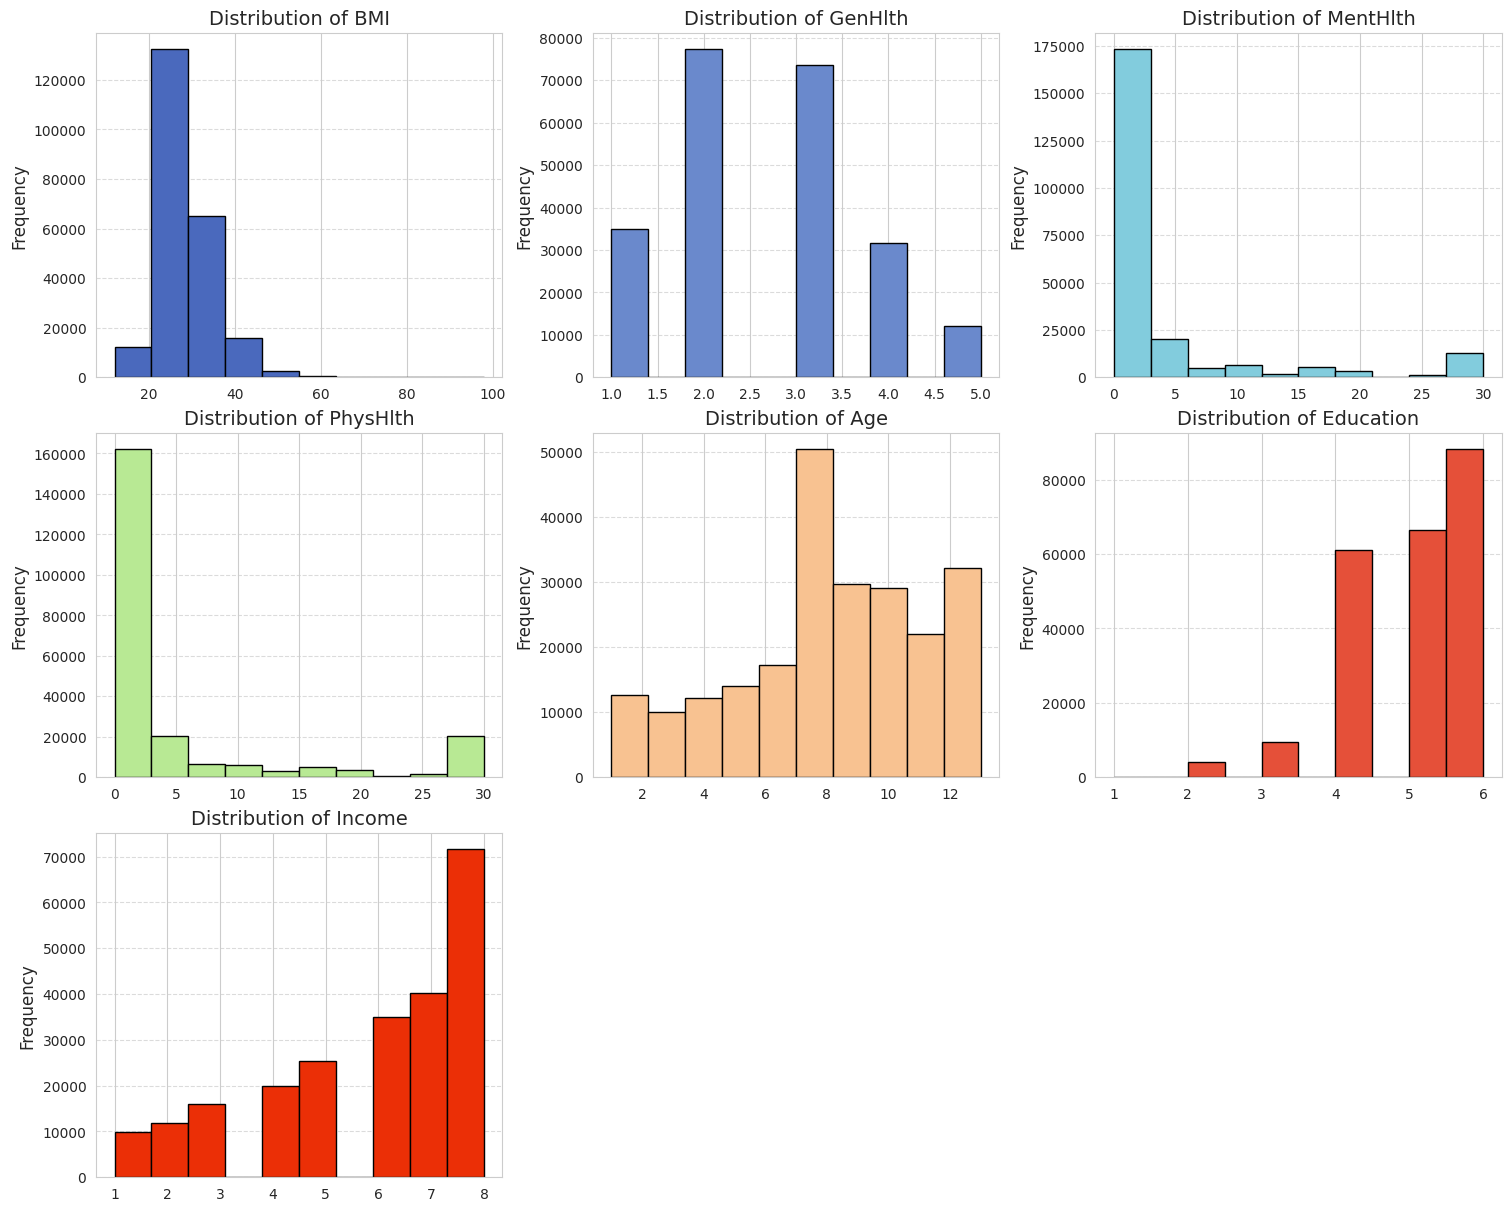

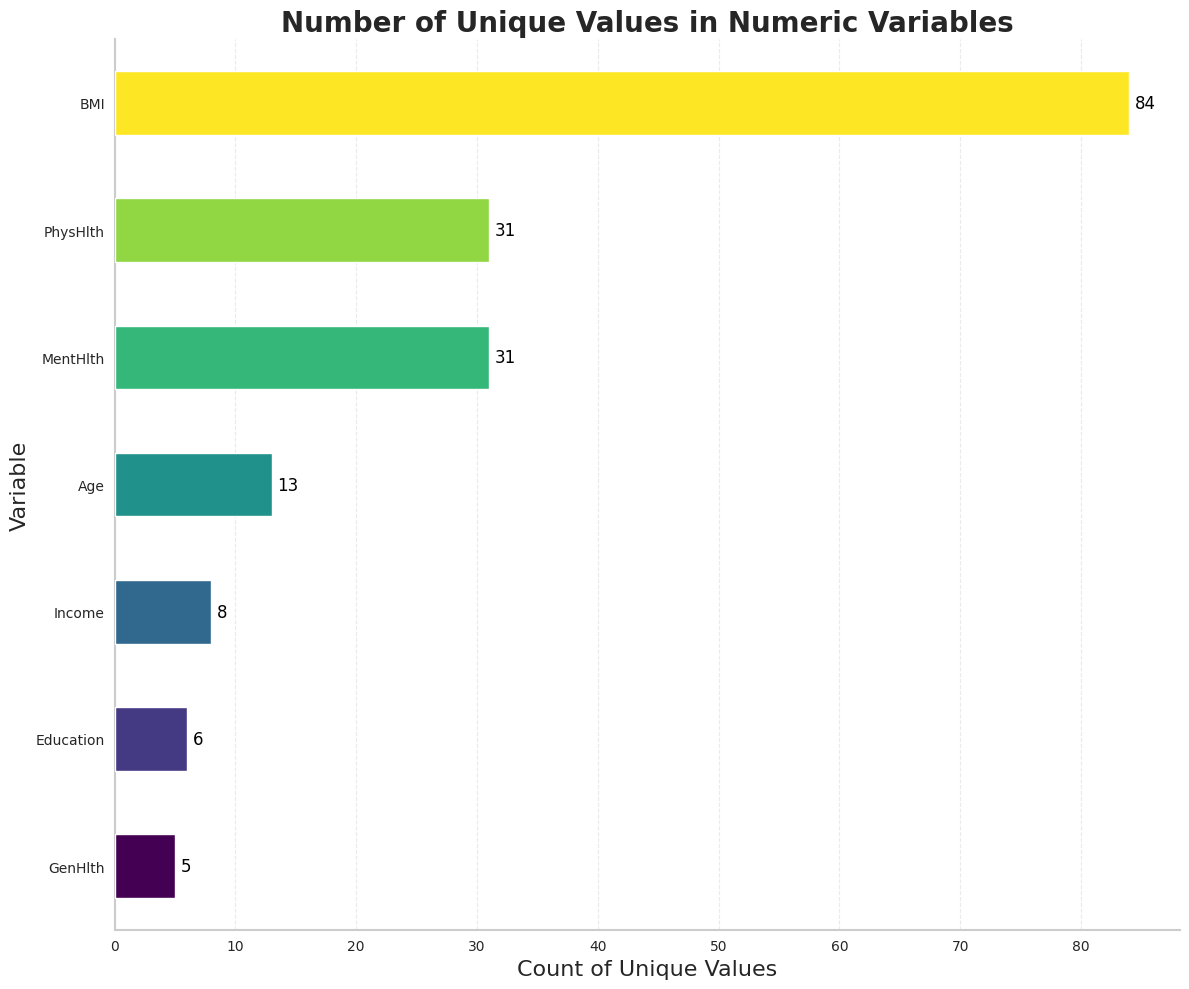

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define unique colors for each histogram
unique_colors = ['#4a69bd', '#6a89cc', '#82ccdd', '#b8e994', '#f8c291', '#e55039', '#eb2f06']

# Calculate the number of rows needed for 7 histograms in 3 columns
num_rows = -(-len(num_vars) // 3)  # Ceiling division to get the number of rows needed

# Generate histograms for numeric variables with unique colors
fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 4 * num_rows), constrained_layout=True)

for i, var in enumerate(num_vars):
    # Calculate row and column index for the current histogram
    row_idx = i // 3
    col_idx = i % 3

    ax = axes[row_idx, col_idx]
    color = unique_colors[i % len(unique_colors)]  # Ensure unique colors even if there are more variables than colors
    df[var].plot(kind='hist', ax=ax, color=color, edgecolor='black')
    ax.set_title(f'Distribution of {var}', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# If there are any empty subplots, hide them
for j in range(i + 1, num_rows * 3):
    fig.delaxes(axes[j // 3, j % 3])

plt.show()

# Calculate the number of unique values for each numeric variable
unique_value_counts = df[num_vars].nunique().sort_values(ascending=True)

# Define colors for the bar plot
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_value_counts)))

# Create the horizontal bar plot with colors
fig, ax = plt.subplots(figsize=(12, 10))
unique_value_counts.plot(kind='barh', color=colors, zorder=3, ax=ax)

# Customize the plot appearance
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['left', 'bottom']].set_linewidth(1.5)  # Emphasize left and bottom spines
ax.xaxis.grid(True, linestyle='--', alpha=0.4)
ax.yaxis.grid(False)

# Add data labels on the bars
for i, value in enumerate(unique_value_counts):
    ax.text(value + 0.5, i, f'{value}', va='center', fontsize=12, color='black')

# Add titles and labels
plt.title('Number of Unique Values in Numeric Variables', fontsize=20, weight='bold')
plt.xlabel('Count of Unique Values', fontsize=16)
plt.ylabel('Variable', fontsize=16)

# Adjust layout for a better fit
plt.tight_layout()

# Show the plot
plt.show()


**Relationship between Variables (Heat Map)**

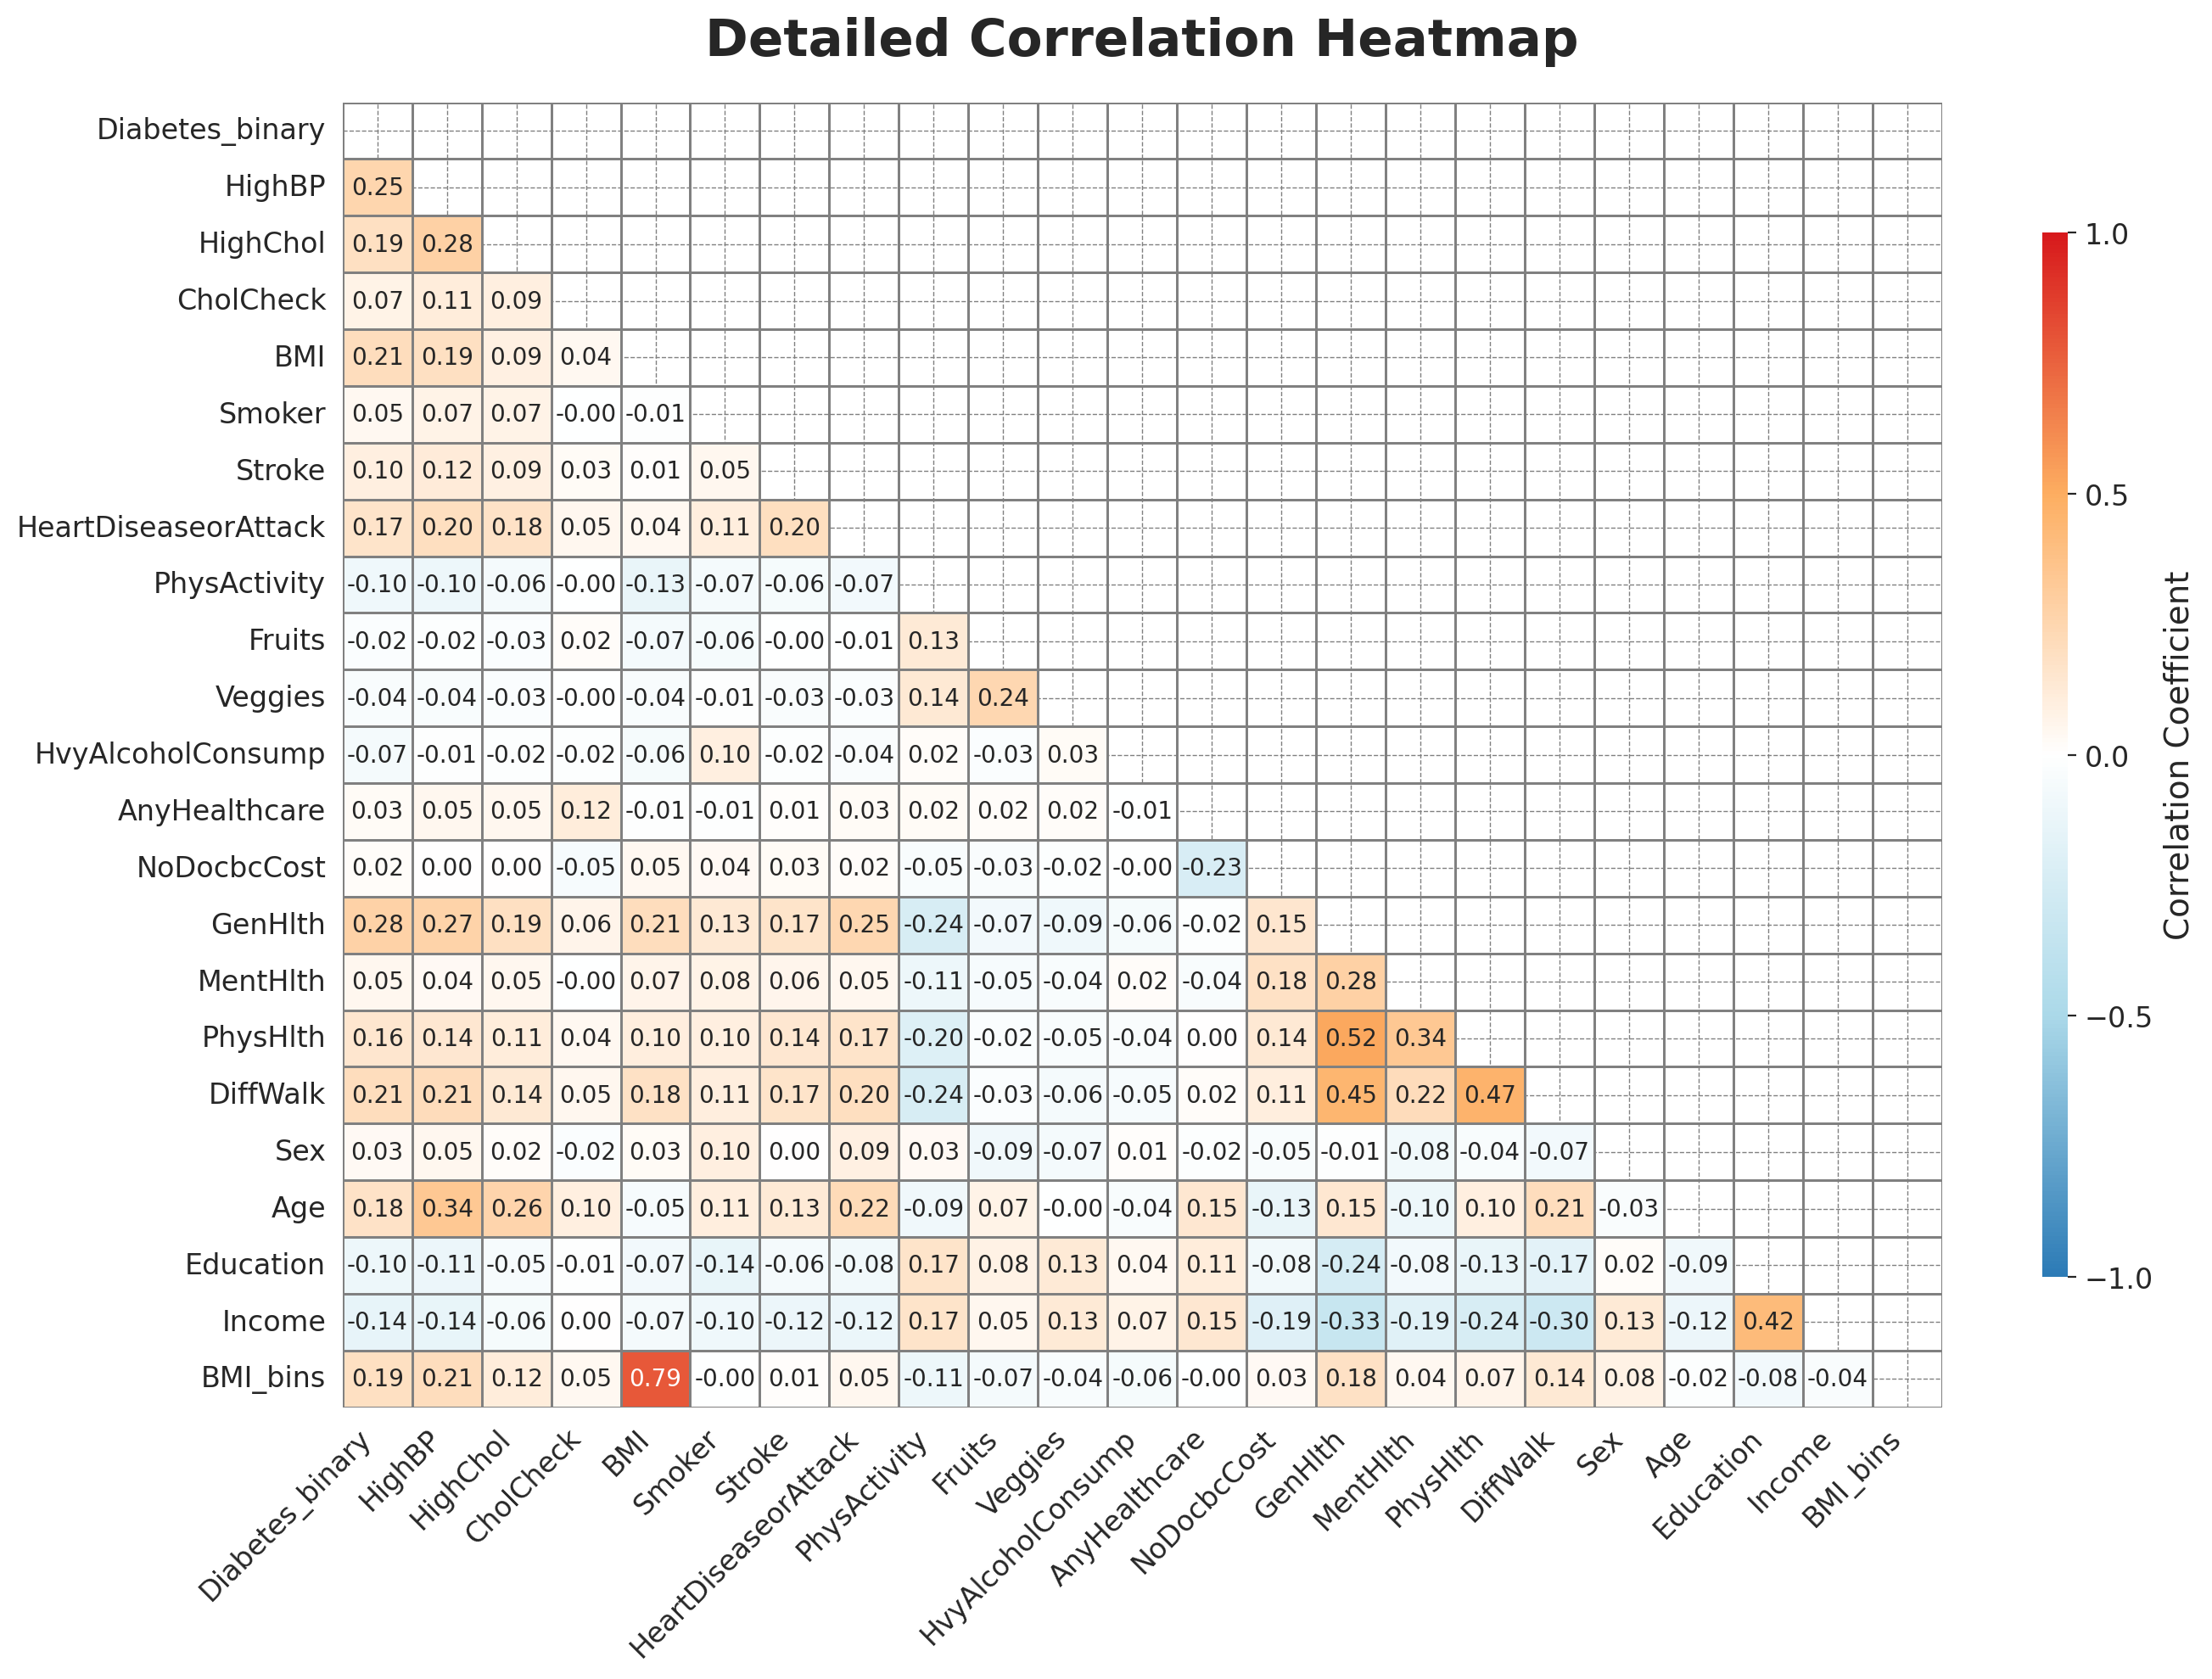

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Assuming df is already defined and is your DataFrame

# Create a copy of the DataFrame for the heatmap
data_heatmap = df.copy()

# Define a new custom color map using a diverging color scheme
new_custom_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'new_custom', ['#2c7bb6', '#abd9e9', '#ffffff', '#fdae61', '#d7191c']
)

# Calculate the correlation matrix
corr_matrix = data_heatmap.corr()

# Create a mask for the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set the new size of the heatmap
new_fig_size = (14, 10)  # Adjust the size (width, height) as needed
fig, ax = plt.subplots(figsize=new_fig_size, dpi=200)

# Create the correlation heatmap with the new color map and more detailed annotations
heatmap = sns.heatmap(corr_matrix, cmap=new_custom_cmap, mask=mask, annot=True, fmt='.2f',
                      vmin=-1, vmax=1, linewidths=0.5, linecolor='gray',
                      cbar_kws={'shrink': 0.8, 'ticks': [-1, -0.5, 0, 0.5, 1], 'aspect': 40})

# Set title and adjust font size
heatmap.set_title('Detailed Correlation Heatmap', fontdict={'fontsize': 22, 'weight': 'bold'}, pad=20)

# Adjust tick label size and rotation
ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust label size as needed
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', fontsize=12)
plt.setp(ax.yaxis.get_majorticklabels(), fontsize=12)

# Customize the color bar with a horizontal orientation
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)  # Set the size of the color bar ticks
cbar.set_label('Correlation Coefficient', size=14)
cbar.ax.tick_params(direction='out')

# Clean up spines and borders
for spine in ax.spines.values():
    spine.set_visible(False)

# Add gridlines for clarity
ax.grid(which='major', axis='both', linestyle='--', linewidth=0.5, color='gray')

# Display the heatmap
plt.tight_layout()  # Adjust layout to fit all elements
plt.show()

**Correlations with Target**

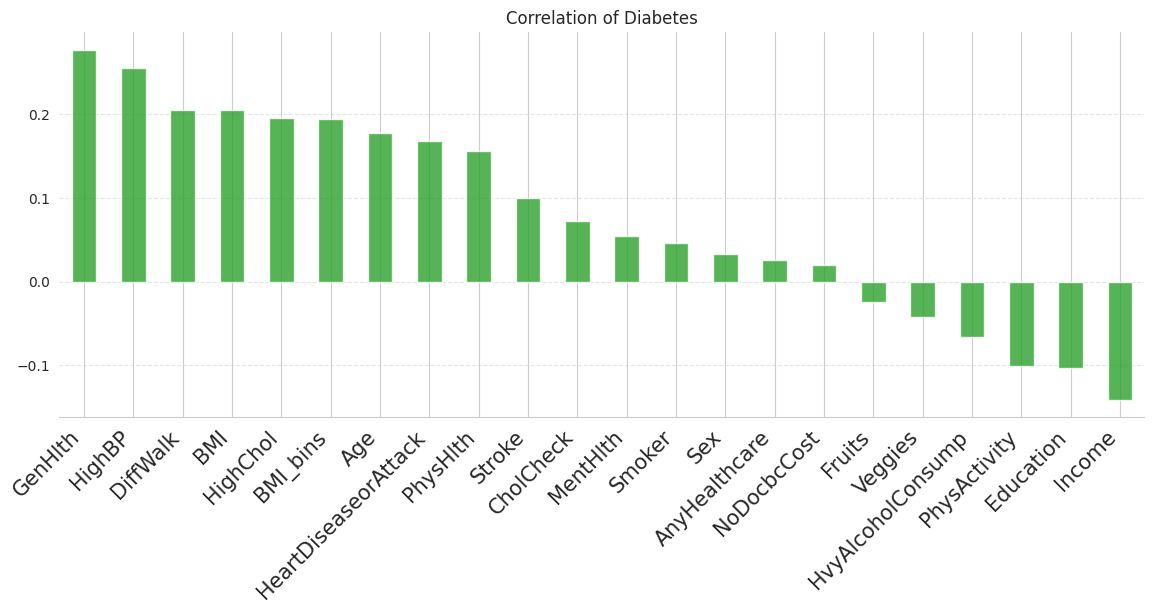

<ipython-input-13-68f4a705bf29>:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=significant_coor.index, y=significant_coor.values, palette=new_palette)
<ipython-input-13-68f4a705bf29>:35: UserWarning: 
The palette list has fewer values (6) than needed (16) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=significant_coor.index, y=significant_coor.values, palette=new_palette)


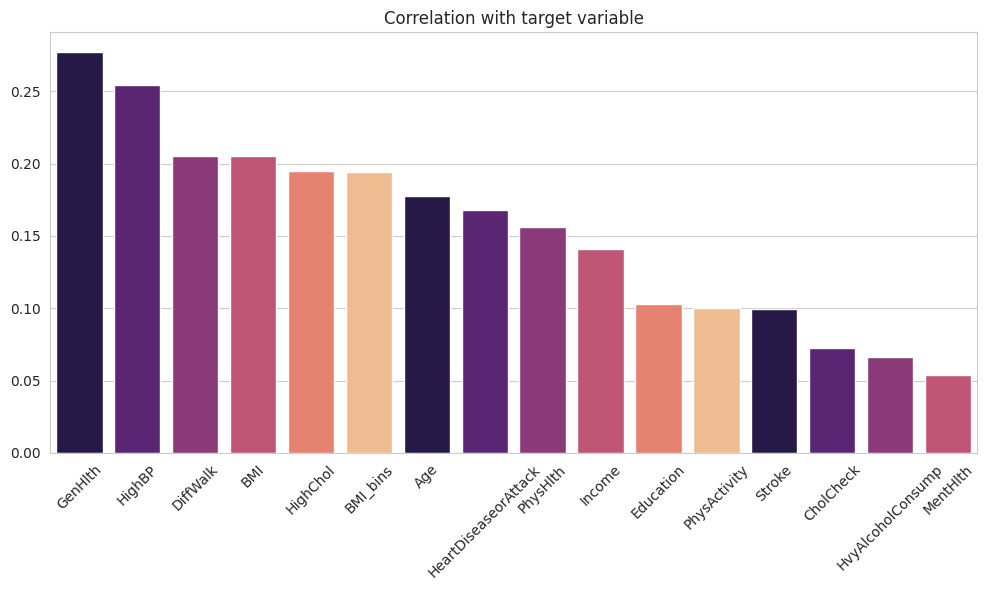

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation of features with 'Diabetes_binary'
correlation_series = df.drop('Diabetes_binary', axis=1).corrwith(df['Diabetes_binary']).sort_values(ascending=False)

# Define a custom color for the first plot
plot_color = '#2ca02c'  # Shade of green

# Create the bar plot for the correlation with 'Diabetes_binary'
ax = correlation_series.plot(kind='bar', figsize=(14, 5), color=plot_color, title="Correlation of Diabetes", alpha=0.8, zorder=3)

# Customize the plot appearance
ax.spines[['top', 'right', 'left']].set_visible(False)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right', size=15)

# Show the plot
plt.show()

# Calculate Pearson correlation coefficients
pear_coor = (df.drop('Diabetes_binary', axis=1)
.corrwith(df.Diabetes_binary)
.abs()
.sort_values(ascending=False))

# Filter correlations greater than 0.05
significant_coor = pear_coor[pear_coor > 0.05]

# Define a new color palette for the second plot
new_palette = sns.color_palette("magma")  # Changed palette to 'magma'

# Plot the significant correlation coefficients with the new color palette
plt.figure(figsize=(10, 6))
sns.barplot(x=significant_coor.index, y=significant_coor.values, palette=new_palette)

plt.title('Correlation with target variable')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Adjust layout
plt.show()


**Feature Selection -**
 **Correlation Coefficient**

<ipython-input-14-7c10a421fd24>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=pear_coor.values, y=pear_coor.index, palette="viridis")


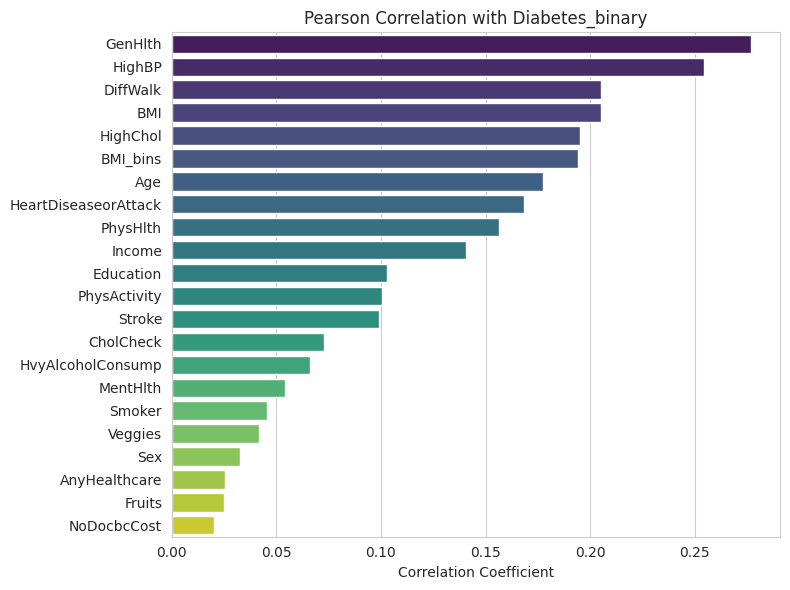

,0
GenHlth,0.276940
HighBP,0.254318
DiffWalk,0.205302
BMI,0.205086
HighChol,0.194944
BMI_bins,0.194376
Age,0.177263
HeartDiseaseorAttack,0.168213
PhysHlth,0.156211
Income,0.140659


In [14]:
# Assuming ’df’ is your DataFrame and ’Diabetes_binary’ is the target column

# Calculate Pearson correlation coefficients
pear_coor = (df.drop('Diabetes_binary', axis=1)
.corrwith(df.Diabetes_binary)
.abs()
.sort_values(ascending=False))

# Plot the correlation coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=pear_coor.values, y=pear_coor.index, palette="viridis")
plt.title('Pearson Correlation with Diabetes_binary')
plt.xlabel('Correlation Coefficient')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Calculate the absolute Pearson correlation with ’Diabetes_binary’
pearson_corr = df.drop('Diabetes_binary', axis=1).corrwith(df['Diabetes_binary']).abs()

# Sort columns by absolute Pearson correlation in descending order
sorted_columns = pearson_corr.sort_values(ascending=False)

# Display the sorted columns
sorted_columns

**1. Pearson Correlation Test**

In [15]:
# Filter columns with Pearson correlation greater than 0.05
filtered_columns = pearson_corr[pearson_corr > 0.05]

# Display the filtered columns
filtered_columns

,0
HighBP,0.254318
HighChol,0.194944
CholCheck,0.072523
BMI,0.205086
Stroke,0.099193
HeartDiseaseorAttack,0.168213
PhysActivity,0.100404
HvyAlcoholConsump,0.065950
GenHlth,0.276940
MentHlth,0.054153


**2.  Chi Square Test**

In [16]:
# Separate features (X) and target variable (y)
X = df.drop('Diabetes_binary', axis=1)
y = df['Diabetes_binary']
# Compute the Chi-squared scores and p-values
f_score, p_values = chi2(X, y)
# Create a DataFrame to store the Chi-squared scores and p-values
chi2_results = pd.DataFrame({'ChiSqr_Score': f_score, 'ChiSqr_pValue':p_values}, index=X.columns)

# Sort the DataFrame by Chi-squared scores in descending order
chi2_results.sort_values(by='ChiSqr_Score', ascending=False, inplace=True)

# Display the sorted Chi-squared scores and p-values
chi2_results
chi2_results

,ChiSqr_Score,ChiSqr_pValue
PhysHlth,97988.761672,0.000000e+00
BMI,15507.736174,0.000000e+00
MentHlth,11419.584750,0.000000e+00
Age,8539.906340,0.000000e+00
HighBP,8098.548237,0.000000e+00
DiffWalk,7875.496177,0.000000e+00
GenHlth,7671.732832,0.000000e+00
HeartDiseaseorAttack,5822.145697,0.000000e+00
HighChol,4869.312739,0.000000e+00
Income,3377.099257,0.000000e+00


**3. Mutual Information**

In [17]:
# Compute mutual information
mutual_info_scores = mutual_info_classif(X[bool_vars], y)

# Create a DataFrame to store the mutual information scores
mutual_info_df = pd.DataFrame(mutual_info_scores, columns=['Mutual_Info'], index=X[bool_vars].columns)

# Sort the DataFrame by mutual information scores in descending order
mutual_info_df_sorted = mutual_info_df.sort_values(by='Mutual_Info', ascending=False)

# Display the sorted mutual information score
mutual_info_df_sorted

,Mutual_Info
HighBP,0.052128
AnyHealthcare,0.047865
CholCheck,0.044908
PhysActivity,0.042343
Veggies,0.038338
HighChol,0.038067
Fruits,0.035548
Smoker,0.024924
DiffWalk,0.022438
Sex,0.021206


**4. F-test statistics and p-values**

In [18]:
# Compute F-test statistics and p-values
f_test_results = f_regression(X, y)

# Create a DataFrame to store the F-test statistics and p-values
f_test_df = pd.DataFrame(f_test_results).T.set_index(X.columns).rename(columns={0: 'f_Statistic', 1: 'f_Reg_pValues'})

# Sort the DataFrame by F-statistic in descending order
f_test_df_sorted = f_test_df.sort_values(by='f_Statistic', ascending=False)

# Display the sorted F-test statistics and p-values
print(f_test_df_sorted)


                       f_Statistic  f_Reg_pValues
GenHlth               19061.436601   0.000000e+00
HighBP                15868.017696   0.000000e+00
DiffWalk              10097.616798   0.000000e+00
BMI                   10075.425186   0.000000e+00
HighChol               9065.177413   0.000000e+00
BMI_bins               9010.331905   0.000000e+00
Age                    7444.458687   0.000000e+00
HeartDiseaseorAttack   6682.140008   0.000000e+00
PhysHlth               5739.591424   0.000000e+00
Income                 4631.714144   0.000000e+00
Education              2445.440895   0.000000e+00
PhysActivity           2336.872150   0.000000e+00
Stroke                 2280.282576   0.000000e+00
CholCheck              1213.321927  3.848806e-265
HvyAlcoholConsump      1002.426607  1.591549e-219
MentHlth                674.908702  1.405556e-148
Smoker                  476.133601  1.899484e-105
Veggies                 400.370333   5.450689e-89
Sex                     245.998296   2.068803e-55


**5. ANOVA test**

In [19]:
# Compute ANOVA F-test statistics and p-values
anova_test_results = f_classif(X[num_vars], y)

# Create a DataFrame to store the ANOVA F-test statistics and p-values
anova_df = pd.DataFrame(anova_test_results).T.set_index(X[num_vars].columns).rename(columns={0: 'f_Statistic', 1: 'ANOVA_pValues'})

# Sort the DataFrame by F-statistic in descending order
anova_df.sort_values(by=['f_Statistic'], ascending=False, inplace=True)
anova_df_sorted = anova_df.copy()

# Display the sorted ANOVA F-test statistics and p-values
print(anova_df_sorted)
anova_df_sorted

            f_Statistic  ANOVA_pValues
GenHlth    19061.433726   0.000000e+00
BMI        10163.821697   0.000000e+00
Age         7444.479505   0.000000e+00
PhysHlth    5739.701978   0.000000e+00
Income      4631.703286   0.000000e+00
Education   2445.635014   0.000000e+00
MentHlth     674.909059  1.405305e-148


,f_Statistic,ANOVA_pValues
GenHlth,19061.433726,0.000000e+00
BMI,10163.821697,0.000000e+00
Age,7444.479505,0.000000e+00
PhysHlth,5739.701978,0.000000e+00
Income,4631.703286,0.000000e+00
Education,2445.635014,0.000000e+00
MentHlth,674.909059,1.405305e-148


 **Model Preparation**

In [20]:
# Function to drop duplicates and reset index
def drop_duplicates_and_reset_index(df):
    dataframe = df.copy()
    dataframe = dataframe.drop_duplicates().reset_index(drop=True)
    return dataframe

# List of columns used from the first experiment (BMI group)
cols_list = ['HighBP', 'HighChol', 'BMI', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity',
             'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Education', 'Income']

# Select features (X) and target variable (y) from the original dataset
X = df[cols_list]
y = df['Diabetes_binary']

# Process the unseen dataset (df2)
df2_clean = drop_duplicates_and_reset_index(df2)
df2_y = df2_clean['Diabetes_binary']
df2_X = df2_clean[cols_list]

# Scaler for feature scaling
scaler = StandardScaler()
scaler.fit(X)

# Transform the features on the unseen dataset (df2)
df2_X_scaled = scaler.transform(df2_X)

**1. Accuracy for Imbalanced Dataset**

In [21]:
# Calculate accuracy and AUC for a baseline model where all predictions are
nodiabetic_acc = accuracy_score(y, np.zeros_like(y))
nodiabetic_uac = roc_auc_score(y, np.zeros_like(y))
# Print the results
print(f'The accuracy for all 0 predictions is {nodiabetic_acc:.4f} and the AUC is {nodiabetic_uac:.4f} in the known and imbalanced dataset')

The accuracy for all 0 predictions is 0.8471 and the AUC is 0.5000 in the known and imbalanced dataset


**2. Accuracy for Balanced Dataset**

In [22]:
# Calculate accuracy and AUC for a baseline model where all predictions areon an unseen balanced dataset
nodiabetic_acc = accuracy_score(df2_y, np.zeros_like(df2_y))
nodiabetic_uac = roc_auc_score(df2_y, np.zeros_like(df2_y))
# Print the results
print(f'The accuracy for all 0 predictions is {nodiabetic_acc:.4f} and the AUC is {nodiabetic_uac:.4f} in the unseen balanced dataset')

The accuracy for all 0 predictions is 0.8471 and the AUC is 0.5000 in the unseen balanced dataset


**Machine Learning Models**

**Models implementation**

In [23]:
# List of machine learning models
clf_rdf = RandomForestClassifier(random_state=508312)
clf_lr = LogisticRegression(max_iter=500, random_state=508312)
clf_KNN = KNeighborsClassifier()
clf_xgb = XGBClassifier(random_state=508312)
clf_catboost = CatBoostClassifier(random_state=508312, verbose=False)
clf_gb = GradientBoostingClassifier(random_state=508312)


**Classification of models(Train and Test)**

In [24]:
def classifiers_models_test(clf_names, clf_list):
    """
    For a given list of classifier names and objects,
    return a DataFrame with model evaluation metrics for training, testing,
    and an unseen dataset.
    """
    info_clf = []
    for count, clf in enumerate(clf_list):

        clf.fit(X_train, y_train)

        # Predict on the training set
        y_pred_train = clf.predict(X_train)
        y_pred_proba_train = clf.predict_proba(X_train)[:, 1]
        acc_score_train = accuracy_score(y_train, y_pred_train)
        auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

        # Predict on the testing set
        y_pred_test = clf.predict(X_test)
        y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
        acc_score_test = accuracy_score(y_test, y_pred_test)
        auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

        # Predict on the balanced unseen dataset (df2)
        y_pred_unseen = clf.predict(df2_X_scaled)
        y_pred_proba_unseen = clf.predict_proba(df2_X_scaled)[:, 1]
        acc_score_unseen = accuracy_score(df2_y, y_pred_unseen)
        auc_score_unseen = roc_auc_score(df2_y, y_pred_proba_unseen)
        rmse_unseen = np.sqrt(mean_squared_error(df2_y, y_pred_unseen))

        info_clf.append([clf_names[count], acc_score_train, auc_score_train, rmse_train,
                         acc_score_test, auc_score_test, rmse_test,
                         acc_score_unseen, auc_score_unseen, rmse_unseen])

    info_df = pd.DataFrame(info_clf, columns=['Model', 'Train_RMSE', 'Train_AUC', 'Train_Accuracy',
                                              'Test_RMSE', 'Test_AUC', 'Test_Accuracy',
                                              'Unseen_RMSE', 'Unseen_AUC', 'Unseen_Accuracy'])
    return info_df


**Prediction with imbalanced dataset**

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64



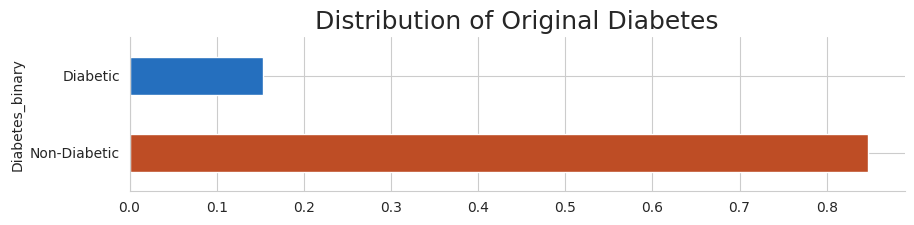


Diabetes_binary
1     28152
0    155427
Name: count, dtype: int64



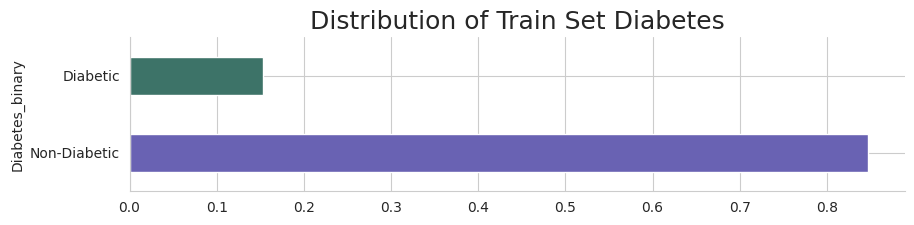

In [25]:
# Split the dataset into training and testing sets BEFORE scaling
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Make sure 'X' refers to the original DataFrame used to fit the scaler
    y,
    test_size=0.2,
    random_state=508312
)

# Fit the scaler to the training data and transform both training and testing sets
scaler.fit(X_train)  # Fit the scaler to the training data ONLY
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Assuming df2_X is the DataFrame for the unseen dataset
# Ensure df2_X has the same columns as X used for fitting the scaler
# Get missing columns in df2_X
missing_cols = set(X.columns) - set(df2_X.columns)

# Add missing columns to df2_X and fill with 0 (or any appropriate value)
for col in missing_cols:
    df2_X[col] = 0

# Reorder columns of df2_X to match X
df2_X = df2_X[X.columns]

# Scale the unseen dataset using the SAME scaler fit on the training data
df2_X_scaled = scaler.transform(df2_X)


# Print and visualize the original distribution of the target variable
print(y.value_counts(ascending=True))
print()
y.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#be4d25', '#256fbe']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Original Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable in the training set
print(y_train.value_counts(ascending=True))
print()
y_train.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#6962b3', '#3d7368']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Train Set Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()

# Define classifier names and objects
clf_names = ['Random_Forest', 'Logistic_Regression', 'K_Neighbors', 'XgBoost', 'CatBoost', 'Gradient_Boosting'] #, 'Gaussian_NB'
clf_list = [clf_rdf, clf_lr, clf_KNN, clf_xgb, clf_catboost, clf_gb] #, clf_gauss_nb

# Evaluate classifiers on the imbalanced dataset
print()
#imbalanced_perf = classifiers_models_test(clf_names, clf_list)
#print('Imbalanced dataset')
#imbalanced_perf

**Comparison of Model Analysis**

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparisons(df):
    # Melt the dataframe to long format for easier plotting with seaborn
    df_long = df.melt(id_vars='Model', var_name='Metric', value_name='Value')

    # Plotting
    plt.figure(figsize=(15, 8))
    sns.barplot(x='Metric', y='Value', hue='Model', data=df_long)

    plt.title('Comparison of Model Performances')
    plt.xticks(rotation=45)
    plt.ylabel('Metric Value')
    plt.xlabel('Metric Type')
    plt.legend(title='Model', loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Assuming imbalanced_perf is the dataframe obtained from classifiers_models_test
#plot_model_comparisons(imbalanced_perf)


**Prediction using Near Miss**

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64



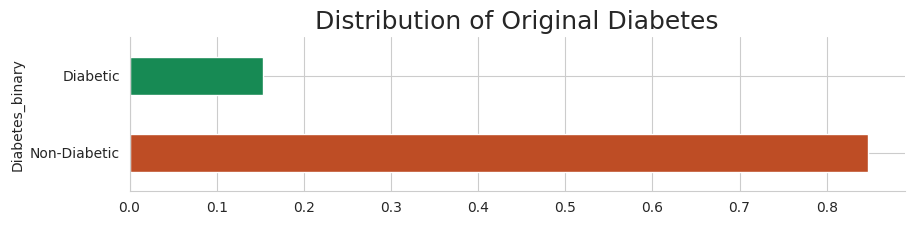


Diabetes_binary
0    28152
1    28152
Name: count, dtype: int64



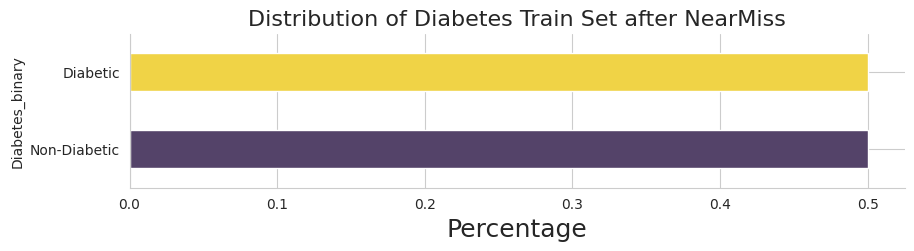


NearMiss
                 Model  Train_RMSE  Train_AUC  Train_Accuracy  Test_RMSE  \
0        Random_Forest    0.954284   0.993823        0.213813   0.373243   
1  Logistic_Regression    0.845890   0.909701        0.392568   0.489748   
2          K_Neighbors    0.855872   0.943321        0.379642   0.540407   
3              XgBoost    0.880524   0.936676        0.345654   0.360758   
4             CatBoost    0.883259   0.939990        0.341674   0.352784   
5    Gradient_Boosting    0.863083   0.924428        0.370024   0.415623   

   Test_AUC  Test_Accuracy  Unseen_RMSE  Unseen_AUC  Unseen_Accuracy  
0  0.608914       0.791680     0.403026    0.668553         0.772641  
1  0.648081       0.714319     0.490504    0.646307         0.713790  
2  0.637300       0.677933     0.551540    0.672157         0.669672  
3  0.561789       0.799526     0.363571    0.562597         0.797765  
4  0.553758       0.804498     0.356053    0.555161         0.802463  
5  0.623740       0.764446     

In [27]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=508312
)

# Apply NearMiss undersampling technique
nm = NearMiss(version=1, n_neighbors=10)
X_train, y_train = nm.fit_resample(X_train, y_train)

# Scale the features using the previously defined scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print and visualize the original distribution of the target variable
print(y.value_counts(ascending=True))
print()
y.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2), color=['#be4d25', '#178a54']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Original Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable in the training set after NearMiss
print(y_train.value_counts())
print()
y_train.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2), color=['#544369', '#f0d346']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Diabetes Train Set after NearMiss', fontsize=16)
plt.xlabel('Percentage', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Evaluate classifiers on the NearMiss balanced dataset
NearMiss_perf = classifiers_models_test(clf_names, clf_list)
print('NearMiss')
print(NearMiss_perf)


**Prediction using Random Under Sampler**

Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64



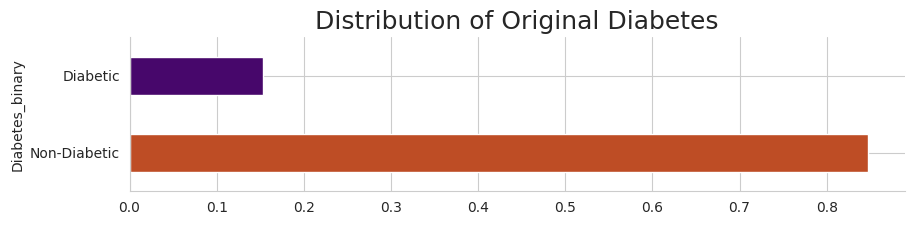


Diabetes_binary
0    28152
1    28152
Name: count, dtype: int64



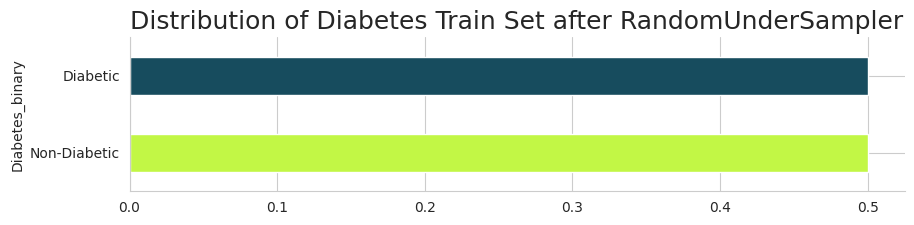


RandomUnderSampler
                 Model  Train_RMSE  Train_AUC  Train_Accuracy  Test_RMSE  \
0        Random_Forest    0.986271   0.999347        0.117171   0.688768   
1  Logistic_Regression    0.733145   0.807241        0.516580   0.717398   
2          K_Neighbors    0.788221   0.874346        0.460194   0.673189   
3              XgBoost    0.771775   0.856768        0.477729   0.702168   
4             CatBoost    0.765878   0.850449        0.483861   0.704064   
5    Gradient_Boosting    0.742025   0.819018        0.507912   0.705632   

   Test_AUC  Test_Accuracy  Unseen_RMSE  Unseen_AUC  Unseen_Accuracy  
0  0.780821       0.557882     0.754813    0.926084         0.495163  
1  0.804948       0.531603     0.716077    0.804516         0.532844  
2  0.752893       0.571674     0.696471    0.804720         0.550935  
3  0.805993       0.545740     0.711388    0.826507         0.537226  
4  0.811663       0.544000     0.711754    0.826184         0.536886  
5  0.813227       0.5

In [28]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=508312
)

# Apply RandomUnderSampler with a balanced sampling strategy
rus = RandomUnderSampler(sampling_strategy=1, random_state=508312)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Scale the features using the previously defined scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print and visualize the original distribution of the target variable
print(y.value_counts())
print()
y.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#be4d25', '#47076b']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Original Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable in the training set after RandomUnderSampler
print(y_train.value_counts(ascending=True))
print()
y_train.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#c2f745', '#174c5e']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Diabetes Train Set after RandomUnderSampler', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Evaluate classifiers on the RandomUnderSampler balanced dataset
RandomSampler_perf = classifiers_models_test(clf_names, clf_list)
print('RandomUnderSampler')
print(RandomSampler_perf)

**Over-Sampling using SMOTE(Synthetic Minority Over-sampling
 Technique)**

Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64



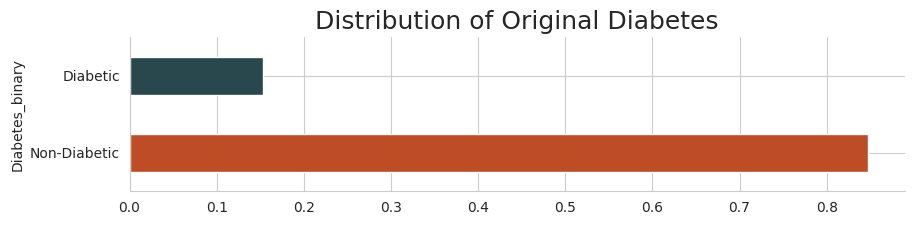


Diabetes_binary
0    155427
1    155427
Name: count, dtype: int64



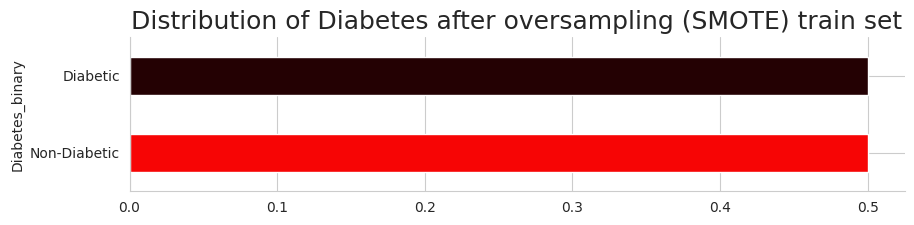



SMOTE
                 Model  Train_RMSE  Train_AUC  Train_Accuracy  Test_RMSE  \
0        Random_Forest    0.986663   0.998877        0.115488   0.824839   
1  Logistic_Regression    0.842321   0.921379        0.397088   0.833947   
2              XgBoost    0.863489   0.941185        0.369474   0.841028   
3             CatBoost    0.872622   0.949338        0.356901   0.838370   
4    Gradient_Boosting    0.857692   0.935709        0.377237   0.833729   

   Test_AUC  Test_Accuracy  Unseen_RMSE  Unseen_AUC  Unseen_Accuracy  
0  0.756750       0.418522     0.949341    0.965975         0.225076  
1  0.790480       0.407496     0.833580    0.789681         0.407946  
2  0.801319       0.398712     0.842418    0.807117         0.396966  
3  0.798027       0.402032     0.848915    0.824516         0.388696  
4  0.803564       0.407763     0.835567    0.803801         0.405503  


In [29]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=508312
)

# Apply SMOTE (oversampling) with a balanced sampling strategy
oversample = SMOTE(sampling_strategy=1, random_state=508312)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Scale the features using the previously defined scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print and visualize the original distribution of the target variable
print(y.value_counts())
print()
y.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#be4d25', '#29484d']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Original Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable in the training set after oversampling (SMOTE)
print(y_train.value_counts(ascending=True))
print()
y_train.value_counts(1).plot(kind='barh', figsize=(10, 2), color=['#f70505', '#240103']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Diabetes after oversampling (SMOTE) train set', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Define a subset of classifiers
clf_names2 = ['Random_Forest', 'Logistic_Regression', 'XgBoost', 'CatBoost', 'Gradient_Boosting'] #, 'Gaussian_NB'
clf_list2 = [clf_rdf, clf_lr, clf_xgb, clf_catboost, clf_gb] #clf_gauss_nb

# Evaluate classifiers on the SMOTE balanced dataset
print()
smote_perf = classifiers_models_test(clf_names2, clf_list2)
print('SMOTE')
print(smote_perf)

**Prediction Over-sampling using SMOTE and NearMiss**

Diabetes_binary
1     35097
0    194377
Name: count, dtype: int64



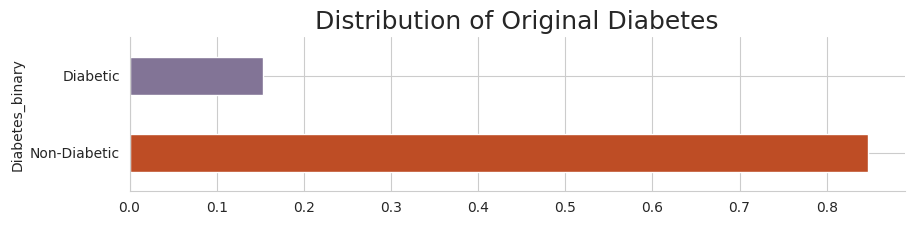


Diabetes_binary
1     62170
0    155427
Name: count, dtype: int64



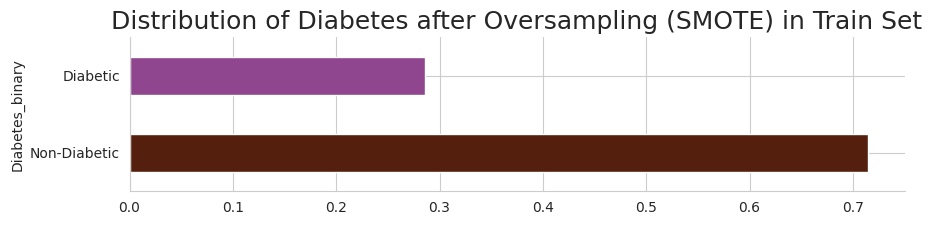


Diabetes_binary
0    62170
1    62170
Name: count, dtype: int64



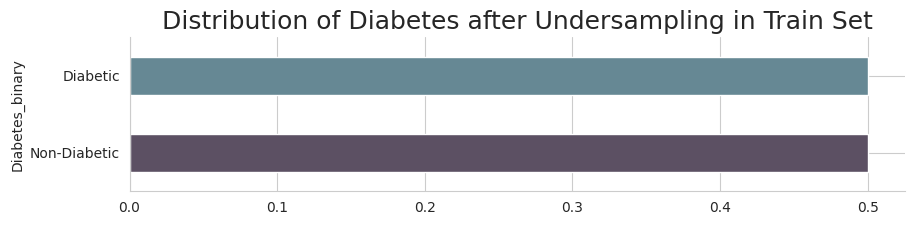



SMOTE and NearMiss
                 Model  Train_RMSE  Train_AUC  Train_Accuracy  Test_RMSE  \
0        Random_Forest    0.973597   0.997751        0.162491   0.532520   
1  Logistic_Regression    0.841362   0.915331        0.398293   0.706874   
2              XgBoost    0.874570   0.939725        0.354161   0.533893   
3             CatBoost    0.880690   0.946389        0.345413   0.523870   
4    Gradient_Boosting    0.861830   0.929619        0.371712   0.570345   

   Test_AUC  Test_Accuracy  Unseen_RMSE  Unseen_AUC  Unseen_Accuracy  
0  0.626527       0.683725     0.586803    0.738674         0.642804  
1  0.738596       0.541411     0.704354    0.737619         0.543733  
2  0.624369       0.682721     0.533699    0.625002         0.682862  
3  0.617501       0.690022     0.525877    0.621436         0.688566  
4  0.677786       0.655480     0.570513    0.676673         0.655352  


In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=508312
)

# Apply SMOTE oversampling with a specific sampling strategy
oversample = SMOTE(sampling_strategy=0.4, random_state=508312)
X_train_smote, y_train_smote = oversample.fit_resample(X_train, y_train)

# Apply NearMiss undersampling with specific parameters
nm = NearMiss(version=1, n_neighbors=10)
X_train, y_train = nm.fit_resample(X_train_smote, y_train_smote)

# Scale the features using the previously defined scaler
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Print and visualize the original distribution of the target variable
print(y.value_counts(ascending=True))
print()
y.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2), color=['#be4d25', '#827496']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Original Diabetes', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable after SMOTE oversampling in the training set
print(y_train_smote.value_counts(ascending=True))
print()
y_train_smote.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2), color=['#54200d', '#8f468e']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Diabetes after Oversampling (SMOTE) in Train Set', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Print and visualize the distribution of the target variable after NearMiss undersampling in the training set
print(y_train.value_counts(ascending=True))
print()
y_train.value_counts(normalize=True).plot(kind='barh', figsize=(10, 2), color=['#5c5063', '#668894']).spines[['top', 'right']].set_visible(False)
plt.title('Distribution of Diabetes after Undersampling in Train Set', fontsize=18)
plt.yticks(ticks=[0, 1], labels=['Non-Diabetic', 'Diabetic'])
plt.show()
print()

# Define a subset of classifiers
clf_names2 = ['Random_Forest', 'Logistic_Regression', 'XgBoost', 'CatBoost', 'Gradient_Boosting']
clf_list2 = [clf_rdf, clf_lr, clf_xgb, clf_catboost, clf_gb]

# Evaluate classifiers on the modified dataset
print()
SMOTE_nm_Sampler_perf = classifiers_models_test(clf_names2, clf_list2)
print('SMOTE and NearMiss')
print(SMOTE_nm_Sampler_perf)


**Improving Feature Selection**

In [32]:
# Get the list of best features from the chi2_list and remove 'BMI_bins'
best_feature_list = chi2_results.index.to_list()
best_feature_list.remove('BMI_bins')
print(best_feature_list)

# Clean the unseen dataset
df2_clean = data_clean(df2)

# Initialize the scaler
scaler = StandardScaler()

# Initialize classifier names and objects
clf_names2 = ['Random_Forest']
clf_list2 = [clf_rdf]

# Initialize the SMOTE oversampler
oversample = SMOTE(sampling_strategy=1, random_state=508312)

# Create an empty DataFrame to store performance results
perfcols_df = pd.DataFrame(columns=[
    'Model', 'Train_RMSE', 'Train_AUC', 'Train_Accuracy',
    'Test_RMSE', 'Test_AUC', 'Test_Accuracy',
    'Unseen_RMSE', 'Unseen_AUC', 'Unseen_Accuracy'
])

# Iterate through selected columns
for num, col in enumerate(best_feature_list, start=1):
    # Define columns to test
    cols_list = best_feature_list[:num]

    # Extract X and y for the main dataset
    X = df[cols_list]
    y = df['Diabetes_binary']

    # Fit the scaler on X
    scaler.fit(X)

    # Extract X and y for the unseen dataset
    df2_X = df2_clean[cols_list]
    df2_y = df2_clean['Diabetes_binary']

    # Scale the unseen dataset features (X)
    df2_X_scaled = scaler.transform(df2_X)

    # Split the main dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X,  # predictive variables
        y,  # target
        test_size=0.2,  # portion of dataset to allocate to test set
        random_state=508312  # seed
    )

    # Apply oversampling using SMOTE
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Scale X_train and X_test
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    print(f'{len(cols_list)} Columns used: {cols_list}')

    # Perform model testing
    smote_perf = classifiers_models_test(clf_names2, clf_list2)

    # Add additional columns to store column information
    smote_perf['columns_names'] = [cols_list]
    smote_perf['columns_size'] = len(cols_list)

    # Append the performance results to the DataFrame
    #perfcols_df = perfcols_df.append(smote_perf, ignore_index=True)
    # Replace the line causing the error with the following:
    perfcols_df = pd.concat([perfcols_df, smote_perf], ignore_index=True)

print('Finished.')

# Reset the index of perfcols_df and drop the old index
perfcols_df.reset_index(drop=True, inplace=True)

['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack', 'HighChol', 'Income', 'Stroke', 'HvyAlcoholConsump', 'PhysActivity', 'Education', 'Smoker', 'Sex', 'NoDocbcCost', 'Veggies', 'Fruits', 'CholCheck', 'AnyHealthcare']
1 Columns used: ['PhysHlth']


<ipython-input-32-9cf8d6541e38>:72: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  perfcols_df = pd.concat([perfcols_df, smote_perf], ignore_index=True)


2 Columns used: ['PhysHlth', 'BMI']
3 Columns used: ['PhysHlth', 'BMI', 'MentHlth']
4 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age']
5 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP']
6 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk']
7 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth']
8 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack']
9 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack', 'HighChol']
10 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack', 'HighChol', 'Income']
11 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack', 'HighChol', 'Income', 'Stroke']
12 Columns used: ['PhysHlth', 'BMI', 'MentHlth', 'Age', 'HighBP', 'DiffWalk', 'GenHlth', 'HeartDiseaseorAttack', 'H

**Best Model Analysis**

In [33]:
# Prepare the training data (X and y)
X = df.drop(['Diabetes_binary', 'BMI_bins'], axis=1)
y = df['Diabetes_binary']

# Initialize the scaler
scaler = StandardScaler()
scaler.fit(X)

# Prepare the unseen dataset (df2) data (X and y)
df2_y = df2_clean['Diabetes_binary']
df2_X = df2_clean.drop(['Diabetes_binary', 'BMI_bins'], axis=1)

# Scaling the features in the unseen dataset (X)
df2_X_scaled = scaler.transform(df2_X)

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X,  # Predictive variables
    y,  # Target
    test_size=0.2,  # Proportion of the dataset allocated to the test set
    random_state=508312  # Seed for randomization
)

# Apply oversampling using SMOTE to balance the classes
oversample = SMOTE(sampling_strategy=1, random_state=508312)
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Scale the features in both X_train and X_test
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Improved Feature Variables**

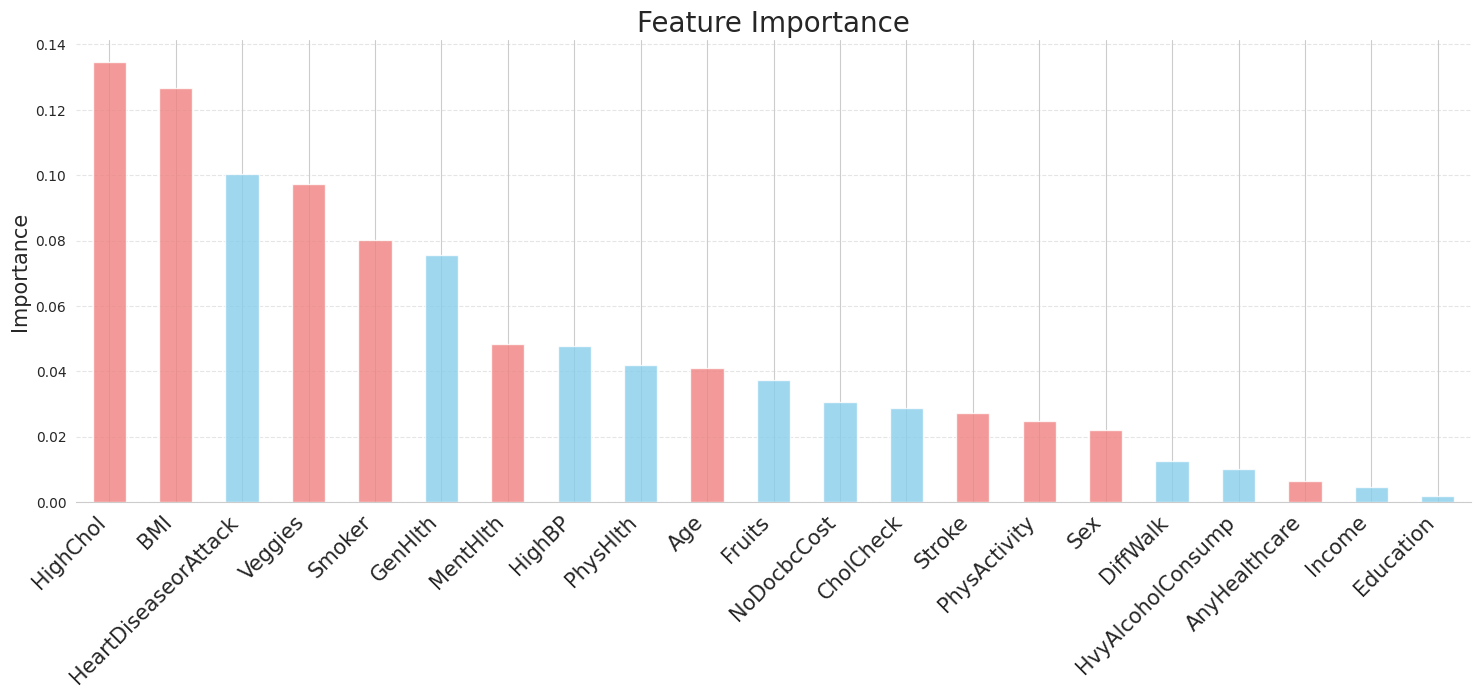

In [34]:
# Assume clf is your trained classifier and X is your feature matrix

# Assume 'clf_rdf' is your trained classifier and X is your feature matrix
clf = clf_rdf # Assign your trained classifier to 'clf'

# Get feature importances
importance = pd.Series(clf.feature_importances_)
importance.index = X.columns.to_list()

# Customize plot colors
colors = ['skyblue' if val <= importance.median() else 'lightcoral' for val in importance]

# Plot feature importance
(importance.sort_values(ascending=False)
 .plot.bar(figsize=(18, 6), title="Feature Importance", alpha=0.8, zorder=3, color=colors)
 .spines[['top', 'right', 'left']].set_visible(False)
)
plt.grid(axis='y', linestyle='--', alpha=.5, zorder=1)
plt.xticks(rotation=45, ha='right', size=15)
plt.xlabel('', size=15)
plt.ylabel('Importance', size=15)
plt.title('Feature Importance', size=20)
plt.show()


**Confusion Matrix**

Random Forest

           Model  Train_Accuracy  Train_AUC  Train_RMSE  Test_Accuracy  \
0  Random_Forest        0.996783   0.999739    0.056718       0.839721   

   Test_AUC  Test_RMSE  Unseen_Accuracy  Unseen_AUC  Unseen_RMSE  
0   0.77414   0.400348         0.963721    0.975643     0.190469  
RandomForest:
              precision    recall  f1-score   support

Non-diabetic       0.97      0.99      0.98    194377
    Diabetic       0.92      0.83      0.88     35097

    accuracy                           0.96    229474
   macro avg       0.95      0.91      0.93    229474
weighted avg       0.96      0.96      0.96    229474



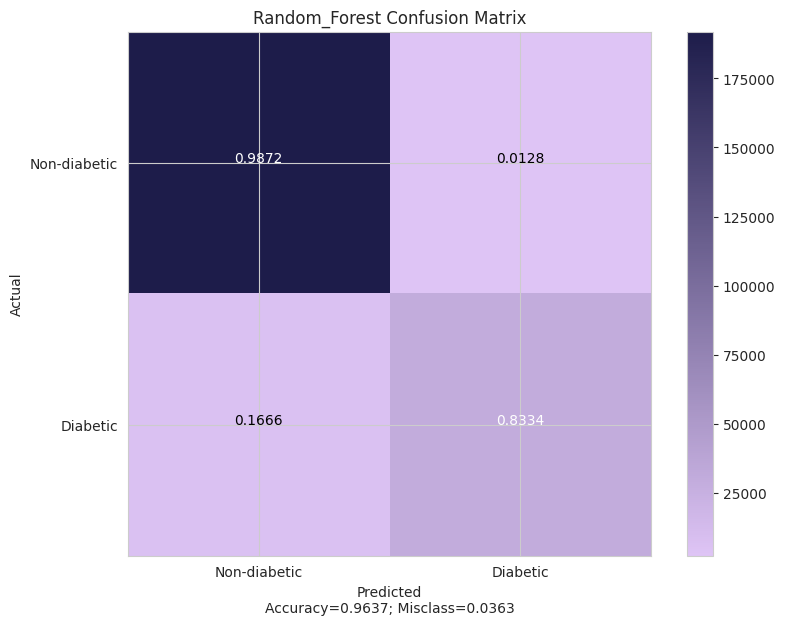

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

# Initialize an empty list to store model performance information
info_clf = []

# Create a Random Forest Classifier with a fixed random state
clf = RandomForestClassifier(random_state=508312)

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Predictions and performance metrics on the training data
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)[:, 1]
acc_score_train = accuracy_score(y_train, y_pred_train)
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Predictions and performance metrics on the test data
y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Predictions and performance metrics on the unseen dataset df2
y_pred_unseen = clf.predict(df2_X_scaled)
y_pred_proba_unseen = clf.predict_proba(df2_X_scaled)[:, 1]
acc_score_unseen = accuracy_score(df2_y, y_pred_unseen)
auc_score_unseen = roc_auc_score(df2_y, y_pred_proba_unseen)
rmse_unseen = np.sqrt(mean_squared_error(df2_y, y_pred_unseen))

# Append the model performance metrics to the info_clf list
info_clf.append(['Random_Forest', acc_score_train, auc_score_train, rmse_train,
                 acc_score_test, auc_score_test, rmse_test,
                 acc_score_unseen, auc_score_unseen, rmse_unseen])

# Create a DataFrame to store the model performance information
info_df = pd.DataFrame(info_clf, columns=['Model', 'Train_Accuracy', 'Train_AUC', 'Train_RMSE',
                                          'Test_Accuracy', 'Test_AUC', 'Test_RMSE',
                                          'Unseen_Accuracy', 'Unseen_AUC', 'Unseen_RMSE'])

print(info_df)

# Confusion matrix plot function
def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap='Blues', normalize=True):
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# Print classification report
print('RandomForest:')
print(classification_report(df2_y, y_pred_unseen, target_names=['Non-diabetic', 'Diabetic']))

# Define target names and custom colormap
target_names = ['Non-diabetic', 'Diabetic']
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#dec4f5', '#1d1c4a'])

# Compute confusion matrix
cm = confusion_matrix(df2_y, y_pred_unseen)

# Adjusted title and normalize=True for better Confusion Matrix
plot_confusion_matrix(cm, target_names, 'Random_Forest Confusion Matrix', custom_cmap, normalize=True)


Random Forest using Class Weights

RandomForest:
              precision    recall  f1-score   support

Non:diabetic       0.97      0.99      0.98    194377
    Diabetic       0.91      0.84      0.87     35097

    accuracy                           0.96    229474
   macro avg       0.94      0.91      0.93    229474
weighted avg       0.96      0.96      0.96    229474



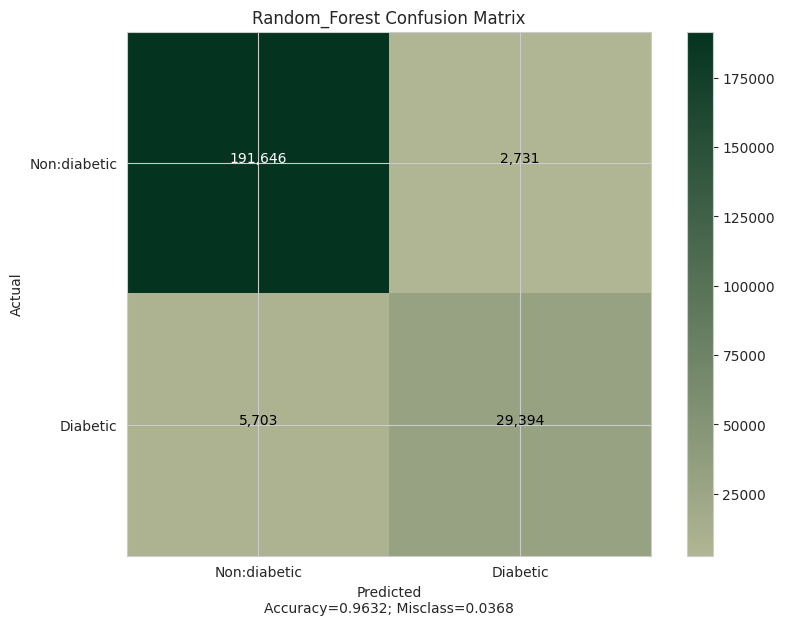

,Model,Train_RMSE,Train_AUC,Train_Accuracy,Test_RMSE,Test_AUC,Test_Accuracy,Unseen_RMSE,Unseen_AUC,Unseen_Accuracy
0,Random_Forest,0.996783,0.999174,0.056718,0.838022,0.772136,0.402465,0.963246,0.973786,0.191712


In [36]:
info_clf = []

# Initialize RandomForestClassifier with class_weight
clf = RandomForestClassifier(random_state=508312, class_weight={0: 1, 1: 20})
clf.fit(X_train, y_train)

# Predictions and performance metrics on X_train
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)[:, 1]
acc_score_train = accuracy_score(y_train, y_pred_train)
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Predictions and performance metrics on X_test
y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Predictions and performance metrics on balanced unseen dataset df2
y_pred_unseen = clf.predict(df2_X_scaled)
y_pred_proba_unseen = clf.predict_proba(df2_X_scaled)[:, 1]
acc_score_unseen = accuracy_score(df2_y, y_pred_unseen)
auc_score_unseen = roc_auc_score(df2_y, y_pred_proba_unseen)
rmse_unseen = np.sqrt(mean_squared_error(df2_y, y_pred_unseen))

# Append the model performance metrics to info_clf list
info_clf.append(['Random_Forest', acc_score_train, auc_score_train, rmse_train,
                 acc_score_test, auc_score_test, rmse_test, acc_score_unseen,
                 auc_score_unseen, rmse_unseen])

# Create a DataFrame to store the model performance information
info_df = pd.DataFrame(info_clf, columns=['Model', 'Train_RMSE', 'Train_AUC',
                                          'Train_Accuracy', 'Test_RMSE', 'Test_AUC',
                                          'Test_Accuracy', 'Unseen_RMSE', 'Unseen_AUC',
                                          'Unseen_Accuracy'])

print('RandomForest:')
print(classification_report(df2_y, y_pred_unseen, target_names=['Non:diabetic', 'Diabetic']))

# Define target names and custom colormap
target_names = ['Non:diabetic', 'Diabetic']
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#b0b593', '#04331f'])

# Compute confusion matrix
cm = confusion_matrix(df2_y, y_pred_unseen)

# Plot confusion matrix with custom settings
plot_confusion_matrix(cm, target_names, 'Random_Forest Confusion Matrix', custom_cmap, normalize=False)

info_df


Random Forest using Class Weights and Decreased Impurity Model

RandomForest:
              precision    recall  f1-score   support

Non:diabetic       0.98      0.88      0.93    194377
    Diabetic       0.57      0.91      0.70     35097

    accuracy                           0.88    229474
   macro avg       0.78      0.89      0.81    229474
weighted avg       0.92      0.88      0.89    229474



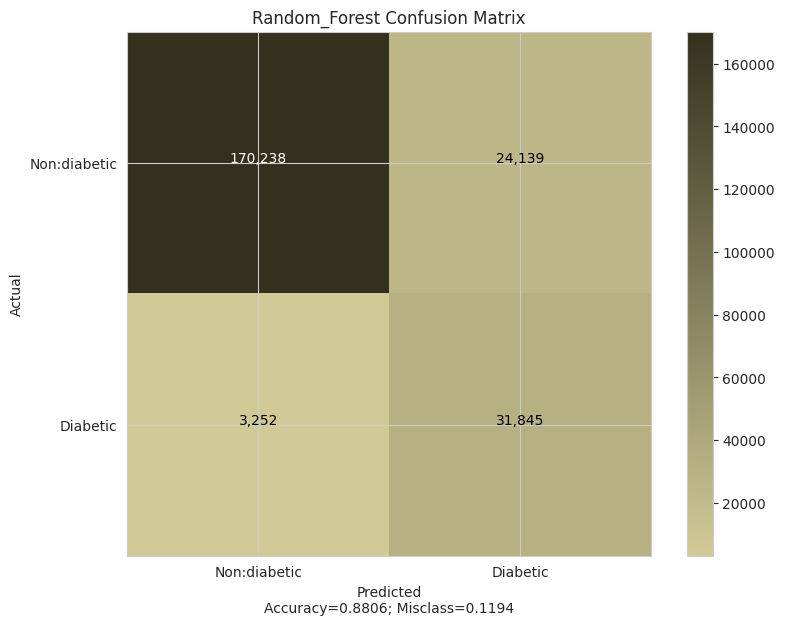

,Model,Train_RMSE,Train_AUC,Train_Accuracy,Test_RMSE,Test_AUC,Test_Accuracy,Unseen_RMSE,Unseen_AUC,Unseen_Accuracy
0,Random_Forest,0.944402,0.996632,0.235793,0.779693,0.78712,0.469369,0.880636,0.951101,0.345491


In [37]:
info_clf = []

# Initialize RandomForestClassifier with class_weight and min_impurity_decrease
clf = RandomForestClassifier(random_state=508312, class_weight={0: 1, 1: 12}, min_impurity_decrease=1e-07)
clf.fit(X_train, y_train)

# Predictions and performance metrics on X_train
y_pred_train = clf.predict(X_train)
y_pred_proba_train = clf.predict_proba(X_train)[:, 1]
acc_score_train = accuracy_score(y_train, y_pred_train)
auc_score_train = roc_auc_score(y_train, y_pred_proba_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

# Predictions and performance metrics on X_test
y_pred_test = clf.predict(X_test)
y_pred_proba_test = clf.predict_proba(X_test)[:, 1]
acc_score_test = accuracy_score(y_test, y_pred_test)
auc_score_test = roc_auc_score(y_test, y_pred_proba_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

# Predictions and performance metrics on balanced unseen dataset df2
y_pred_unseen = clf.predict(df2_X_scaled)
y_pred_proba_unseen = clf.predict_proba(df2_X_scaled)[:, 1]
acc_score_unseen = accuracy_score(df2_y, y_pred_unseen)
auc_score_unseen = roc_auc_score(df2_y, y_pred_proba_unseen)
rmse_unseen = np.sqrt(mean_squared_error(df2_y, y_pred_unseen))

# Append the model performance metrics to info_clf list
info_clf.append(['Random_Forest', acc_score_train, auc_score_train, rmse_train,
                 acc_score_test, auc_score_test, rmse_test, acc_score_unseen,
                 auc_score_unseen, rmse_unseen])

# Create a DataFrame to store the model performance information
info_df = pd.DataFrame(info_clf, columns=['Model', 'Train_RMSE', 'Train_AUC',
                                          'Train_Accuracy', 'Test_RMSE', 'Test_AUC',
                                          'Test_Accuracy', 'Unseen_RMSE', 'Unseen_AUC',
                                          'Unseen_Accuracy'])

print('RandomForest:')
print(classification_report(df2_y, y_pred_unseen, target_names=['Non:diabetic', 'Diabetic']))

# Define target names and custom colormap
target_names = ['Non:diabetic', 'Diabetic']
custom_cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#d1ca97', '#33301d'])

# Compute confusion matrix
cm = confusion_matrix(df2_y, y_pred_unseen)

# Plot confusion matrix with custom settings
plot_confusion_matrix(cm, target_names, 'Random_Forest Confusion Matrix', custom_cmap, normalize=False)

info_df